In [109]:
# Import needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import seaborn as sns
import ast
import lightgbm as lgb
import xgboost as xgb

import requests
from io import BytesIO

from PIL import Image

import eli5

import catboost

import urllib

from wordcloud import WordCloud
from collections import Counter
from sklearn import feature_extraction
from sklearn import preprocessing
from datetime import datetime
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

#define fonts for graphs below
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 18}

matplotlib.rc('font', **font)


In [110]:
# load in datasets
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

print(test.shape)
print(train.shape)
train.info()

(4398, 22)
(3000, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-nu

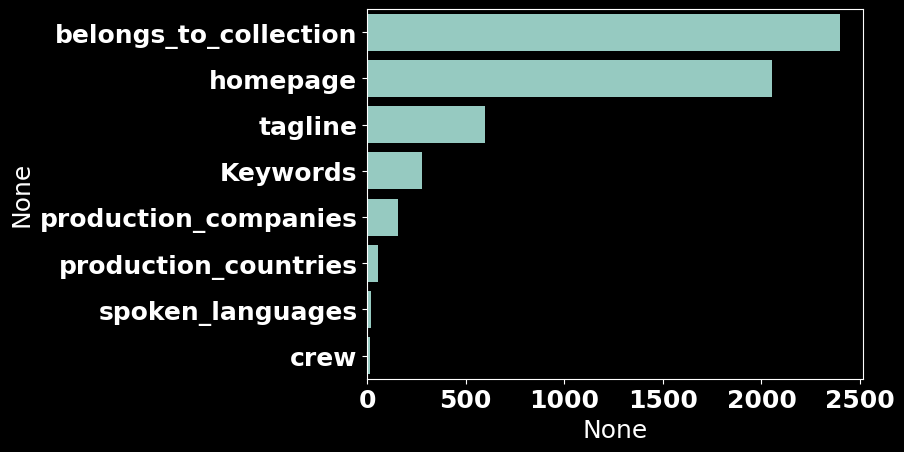

In [111]:
#Show plot of features with most missing data
missing=train.isna().sum().sort_values(ascending=False)
sns.barplot(x= missing[:8],y= missing[:8].index)
plt.style.use('dark_background')
plt.show()

In [112]:
# Converts unknown data into a dictionary and applies it to the training set
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew',]

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df
        
dfx = text_to_dict(train)
for col in dict_columns:
       train[col]=dfx[col]

In [113]:
#finds number of missinf for belongs to a collection feature
train['belongs_to_collection'].apply(lambda x:len(x) if x!= {} else 0).value_counts()

0    2396
1     604
Name: belongs_to_collection, dtype: int64

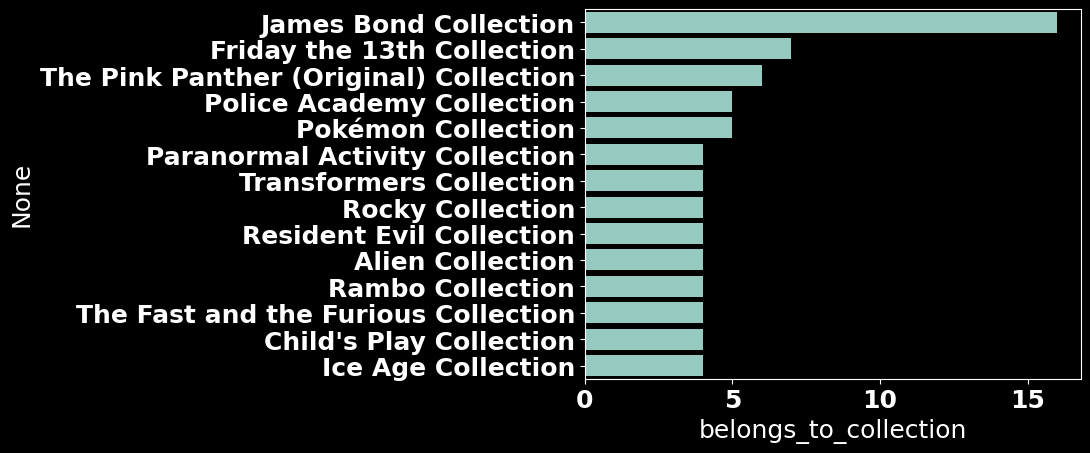

In [114]:
# finds counts of movies in biggest collections
collections=train['belongs_to_collection'].apply(lambda x : x[0]['name'] if x!= {} else '?').value_counts()[1:15]
sns.barplot(x=collections,y=collections.index)
plt.show()

In [115]:
train['tagline'].apply(lambda x:1 if x is not np.nan else 0).value_counts()

1    2403
0     597
Name: tagline, dtype: int64

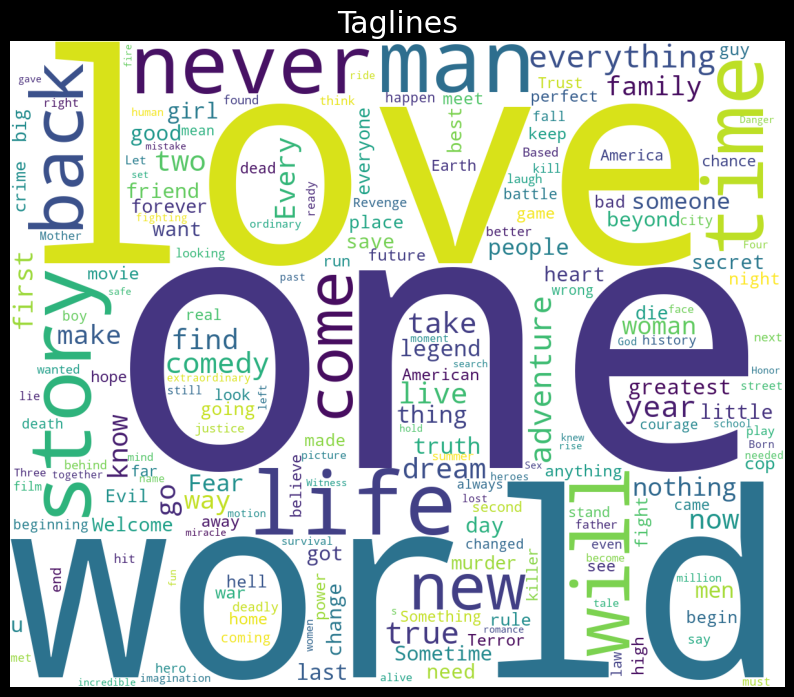

In [116]:
#Creates a word cloud with most popular words in a tagline
plt.figure(figsize=(10,10))
taglines=' '.join(train['tagline'].apply(lambda x:x if x is not np.nan else ''))

wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1200, height=1000).generate(taglines)
plt.imshow(wordcloud)
plt.title('Taglines')
plt.axis("off")
plt.show()


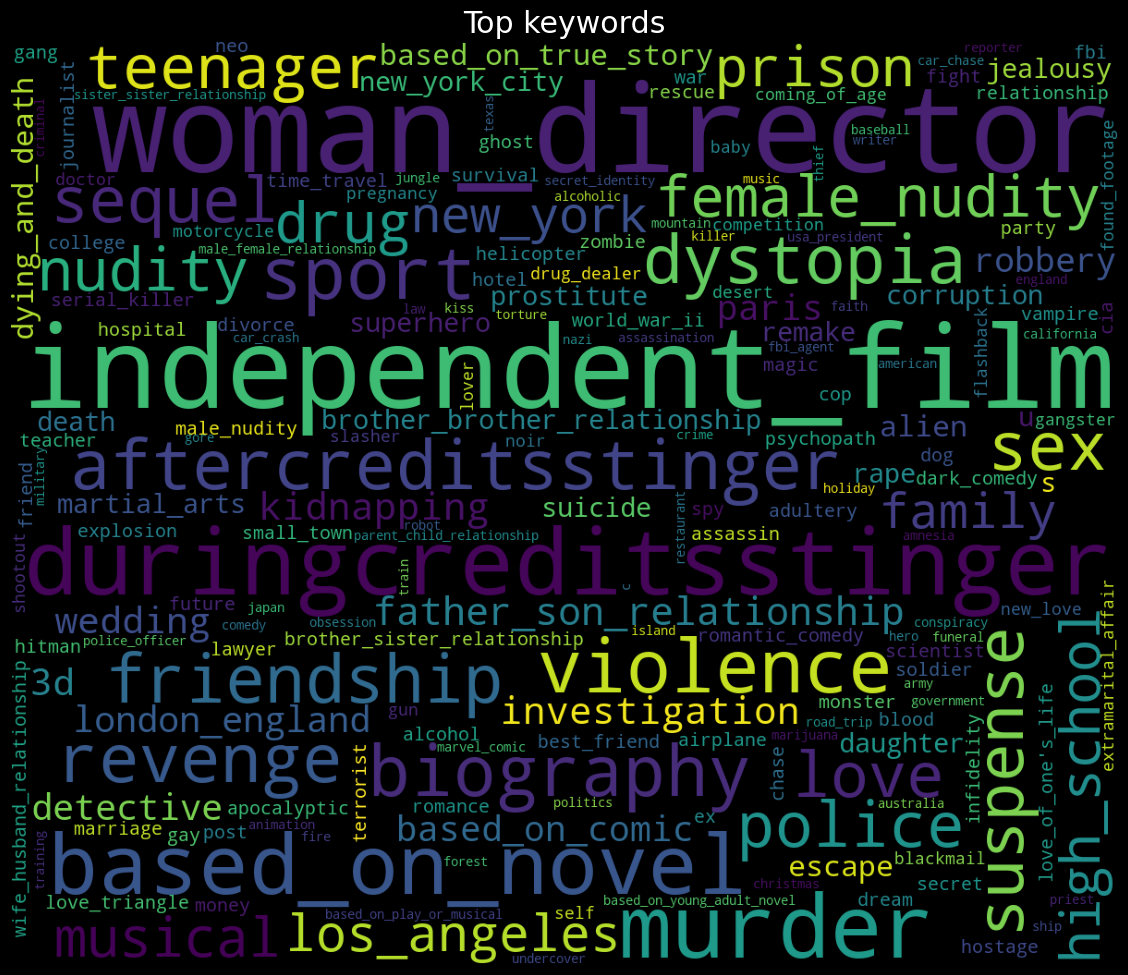

In [117]:
#Does same as above but for keywords
list_of_keywords = list(train['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
plt.figure(figsize = (16, 12))
text = ' '.join(['_'.join(i.split(' ')) for j in list_of_keywords for i in j])
wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False,
                      width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top keywords')
plt.axis("off")
plt.show()

<AxesSubplot: >

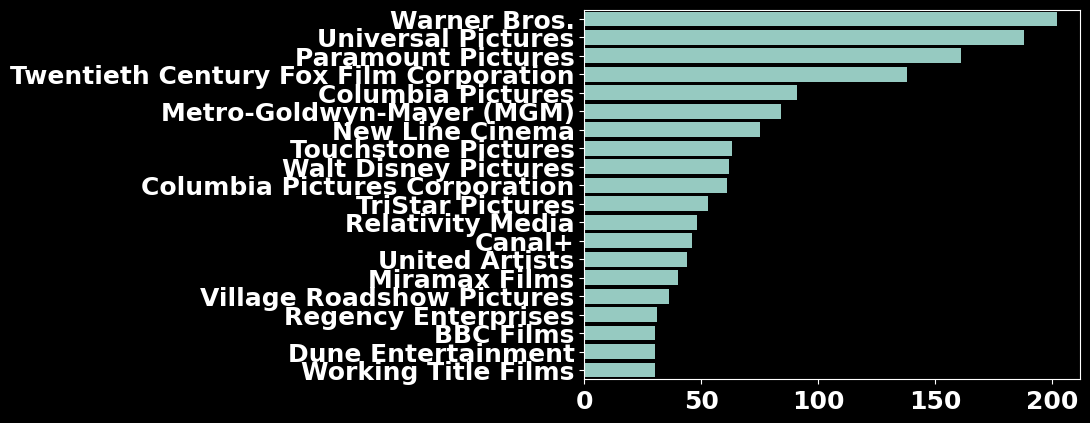

In [118]:
#Plots 20 most common production companies
x=train['production_companies'].apply(lambda x : [x[i]['name'] for i in range(len(x))] if x != {} else []).values
count=Counter([i for j in x for i in j]).most_common(20)
sns.barplot(x=[val[1] for val in count],y=[val[0] for val in count])

<AxesSubplot: >

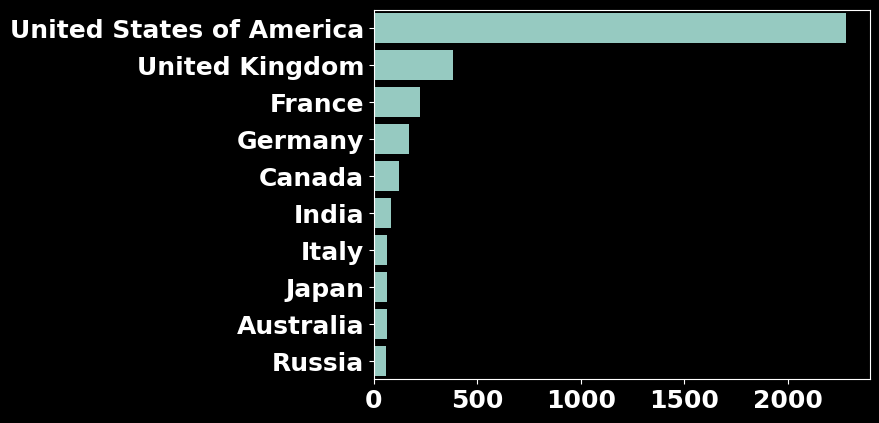

In [119]:
#Plots 10 most common movies are produced in
countries=train['production_countries'].apply(lambda x: [i['name'] for i in x] if x!={} else []).values
count=Counter([j for i in countries for j in i]).most_common(10)
sns.barplot(x=[val[1] for val in count],y=[val[0] for val in count])

In [120]:
#Number of films spoken in each language
train['spoken_languages'].apply(lambda x:len(x) if x !={} else 0).value_counts()

1    2105
2     549
3     216
4      72
5      23
0      20
7       6
6       6
8       2
9       1
Name: spoken_languages, dtype: int64

<AxesSubplot: >

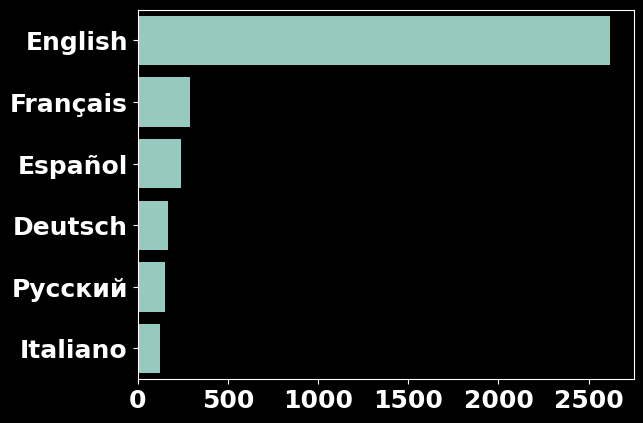

In [121]:
# Plots number of films spoken in a language
lang=train['spoken_languages'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
count=Counter([i for j in lang for i in j]).most_common(6)
sns.barplot(x=[val[1] for val in count],y=[val[0] for val in count])

<AxesSubplot: >

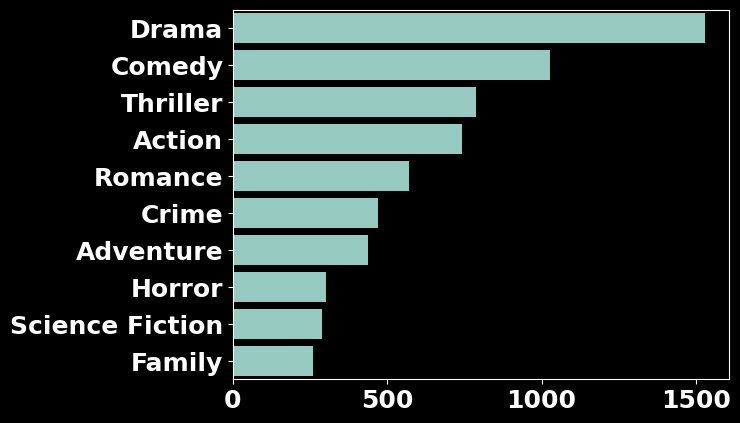

In [122]:
#plots most common genres
genre=train['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
count=Counter([i for j in genre for i in j]).most_common(10)
sns.barplot(x=[val[1] for val in count],y=[val[0] for val in count])

In [123]:
dfx = text_to_dict(test)
for col in dict_columns:
  test[col]=dfx[col]
     
#Takes the log to make revenue more normally distributed

train['log_revenue']=np.log1p(train['revenue'])
     

train['revenue'].describe()

count    3.000000e+03
mean     6.672585e+07
std      1.375323e+08
min      1.000000e+00
25%      2.379808e+06
50%      1.680707e+07
75%      6.891920e+07
max      1.519558e+09
Name: revenue, dtype: float64

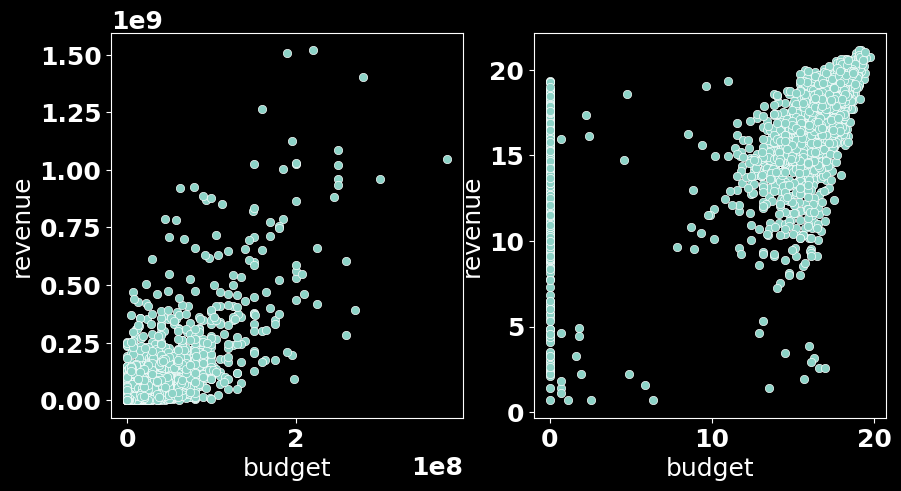

In [124]:
#Scatter plots showing budget vs revenue and then normally distributed
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.scatterplot(x=train['budget'],y=train['revenue'])
plt.subplot(1,2,2)
sns.scatterplot(x=np.log1p(train['budget']),y=np.log1p(train['revenue']))
plt.show()

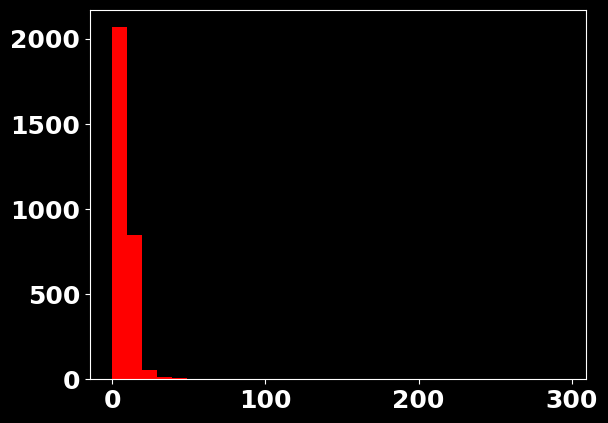

In [125]:
train['log_budget']=np.log1p(train['budget'])
     
# Plots histogram showing how popular movies were

plt.hist(train['popularity'],bins=30,color='red')
plt.show()

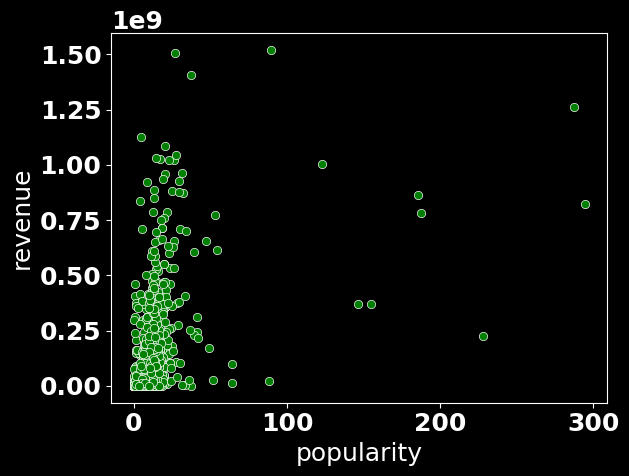

In [126]:
# Plots a comparison of how popularity affects revenue
sns.scatterplot(x=train['popularity'],y=train['revenue'],color='green')
plt.show()

In [130]:
# Breaks up release date into individual date attributes. Errors out but does what is needed to continue
def date(x):
    x=str(x)
    year=x.split('/')[2]
    if int(year)<19:
        return x[:-2]+'20'+year
    else:
        return x[:-2]+'19'+year

train['release_date']=train['release_date'].fillna('1/1/90').apply(lambda x: date(x))
test['release_date']=test['release_date'].fillna('1/1/90').apply(lambda x: date(x))

train['release_date']=train['release_date'].apply(lambda x: datetime.strptime(x,'%m/%d/%Y'))
test['release_date']=test['release_date'].apply(lambda x: datetime.strptime(x,'%m/%d/%Y'))

train['release_day']=train['release_date'].apply(lambda x:x.weekday())
train['release_month']=train['release_date'].apply(lambda x:x.month)
train['release_year']=train['release_date'].apply(lambda x:x.year)

test['release_day']=test['release_date'].apply(lambda x:x.weekday())
test['release_month']=test['release_date'].apply(lambda x:x.month)
test['release_year']=test['release_date'].apply(lambda x:x.year)

day=train['release_day'].value_counts().sort_index()
sns.barplot(x=day.index,y=day)
plt.gca().set_xticklabels(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],rotation=45)
plt.ylabel('No of releases')

IndexError: list index out of range

C:\Users\adamc\AppData\Local\Temp\ipykernel_8720\2223524877.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],rotation=90)


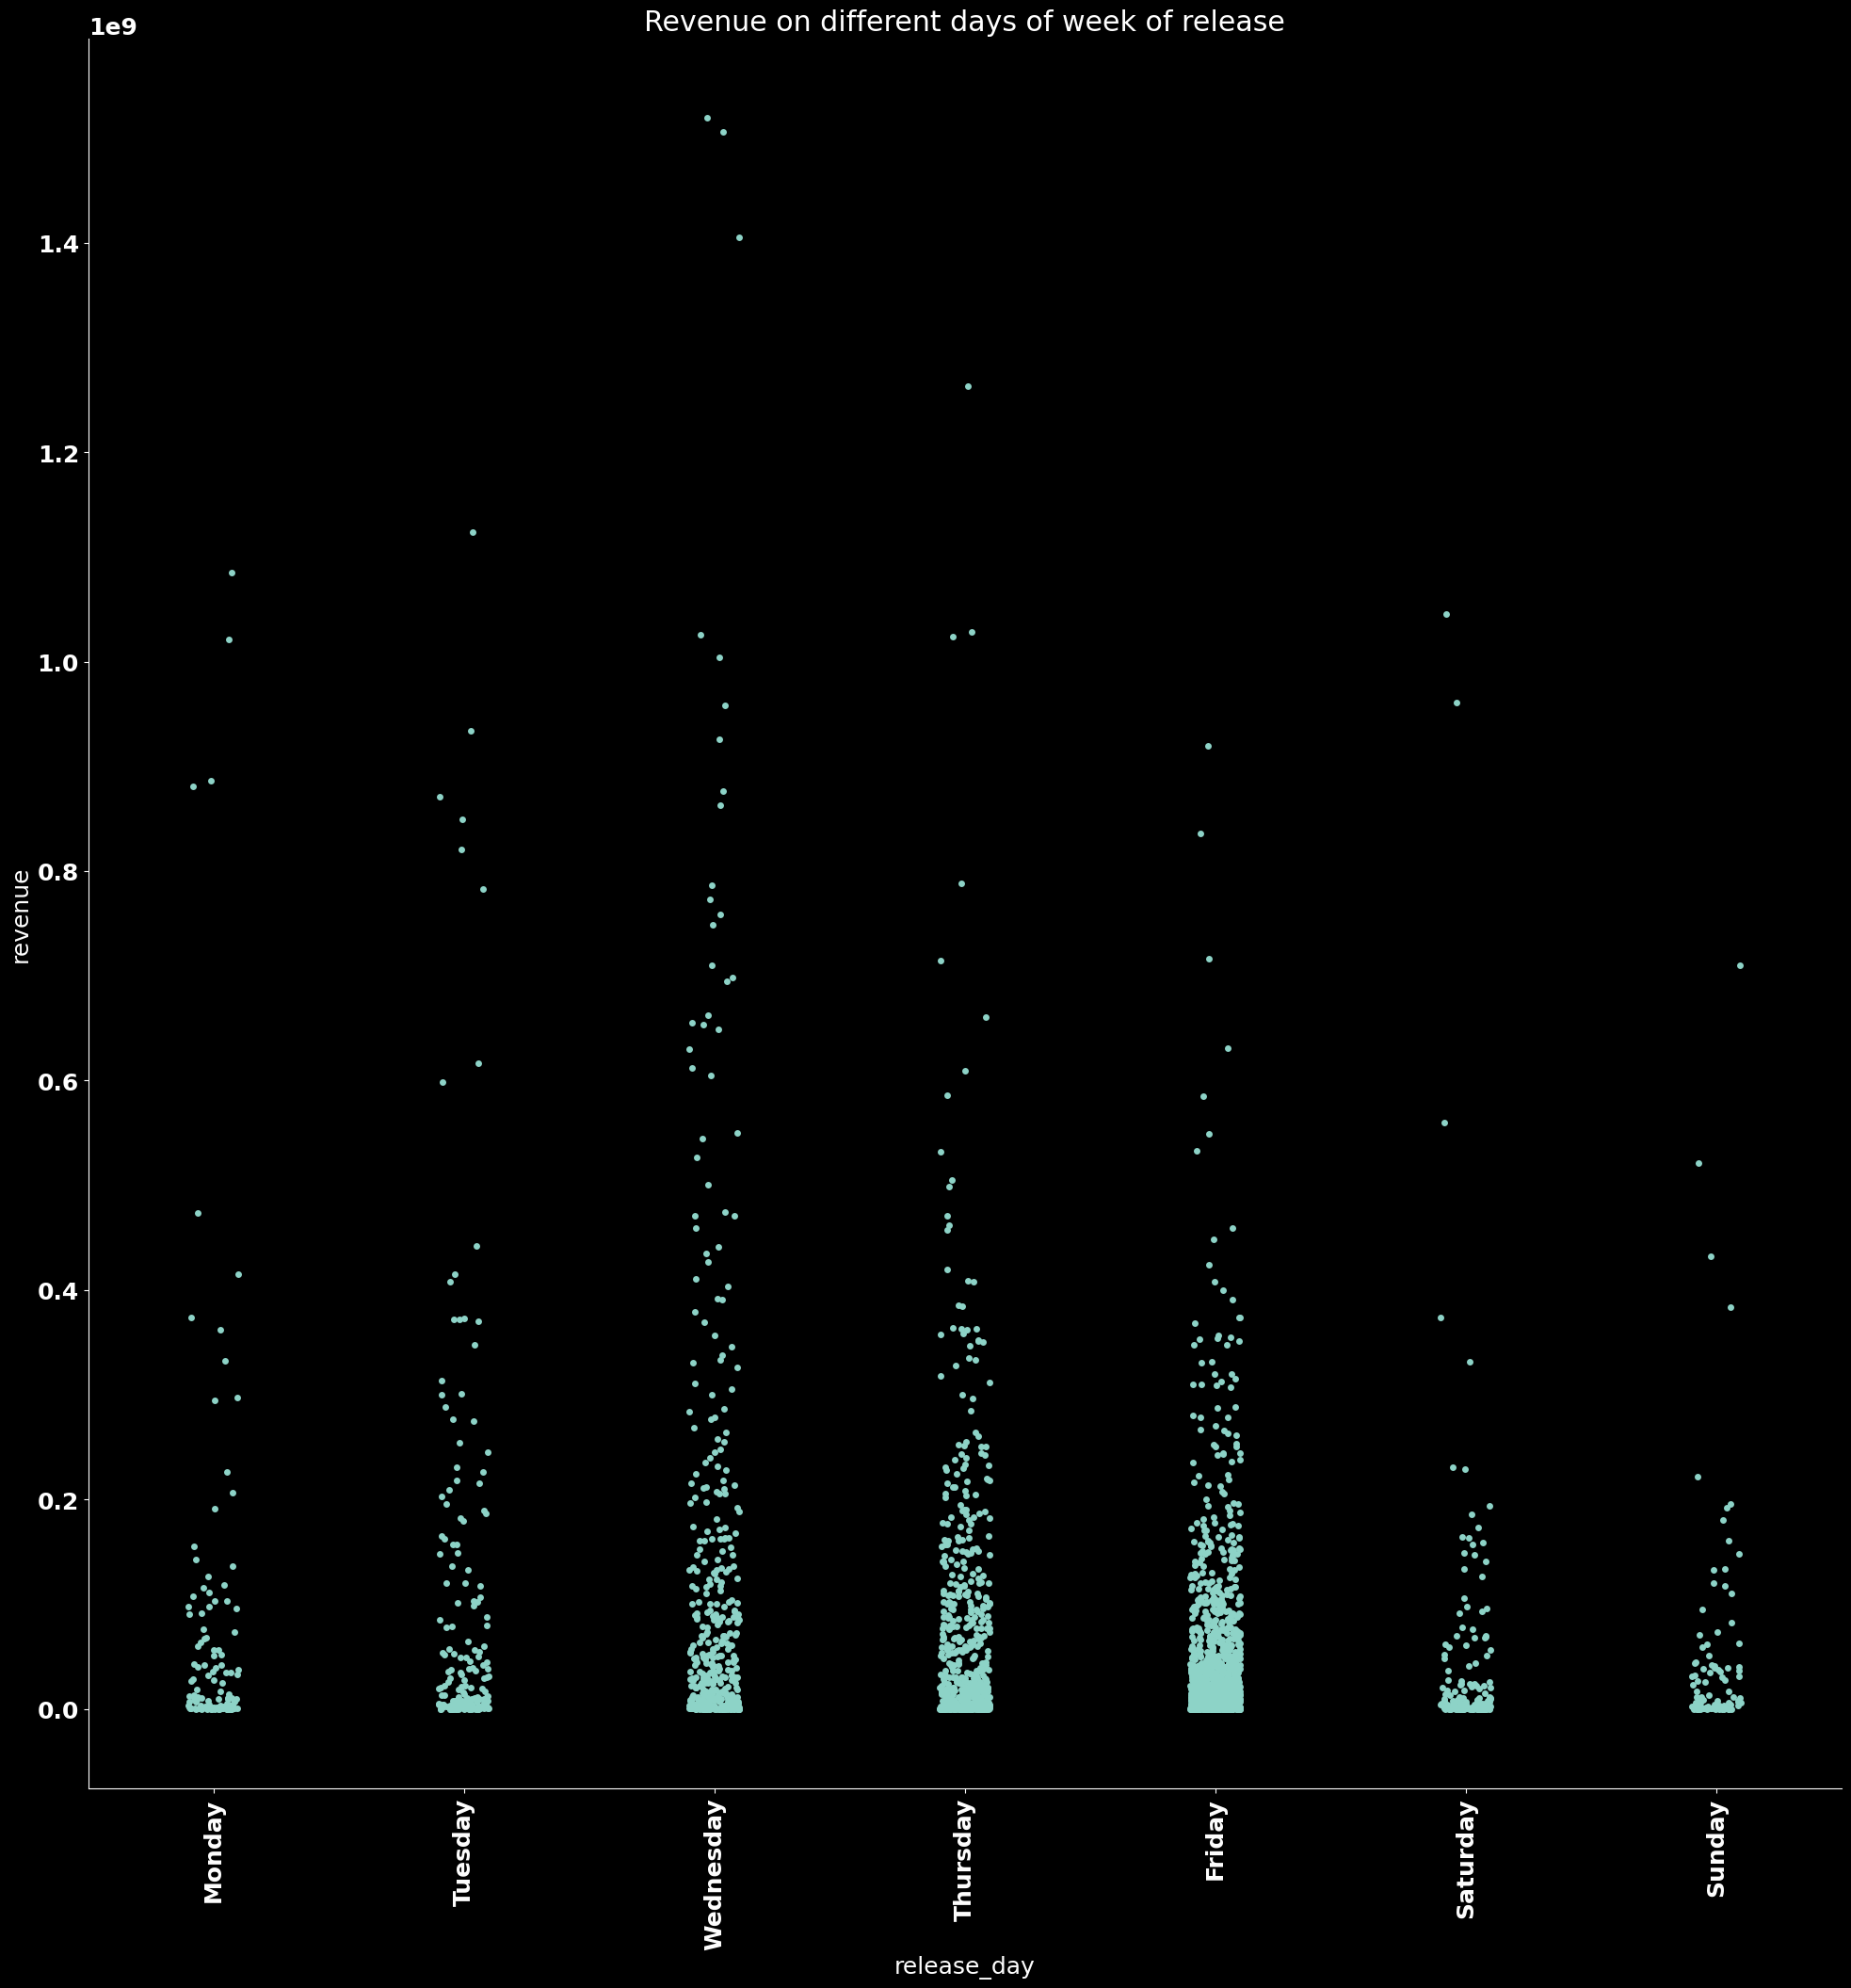

In [131]:
# plots possible correlation between release day (of week) and revenue 
sns.catplot(x='release_day',y='revenue',data=train, height=20, aspect=1)
plt.gca().set_xticklabels(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],rotation=90)
plt.title('Revenue on different days of week of release');
plt.show()

C:\Users\adamc\AppData\Local\Temp\ipykernel_8720\3444560891.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],rotation=45)


Text(0, 0.5, 'No of releases')

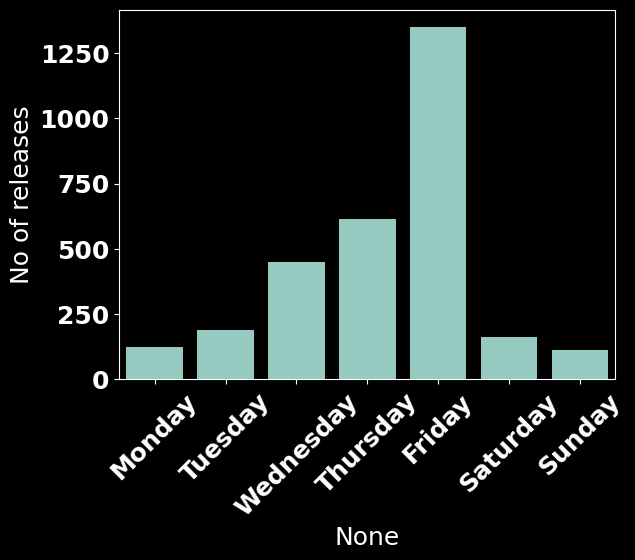

In [134]:
# Shows count of number of movies and days they were released
day=train['release_day'].value_counts().sort_index()
sns.barplot(x=day.index,y=day)
plt.gca().set_xticklabels(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],rotation=45)
plt.ylabel('No of releases')

C:\Users\adamc\AppData\Local\Temp\ipykernel_8720\970550052.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],rotation=90)


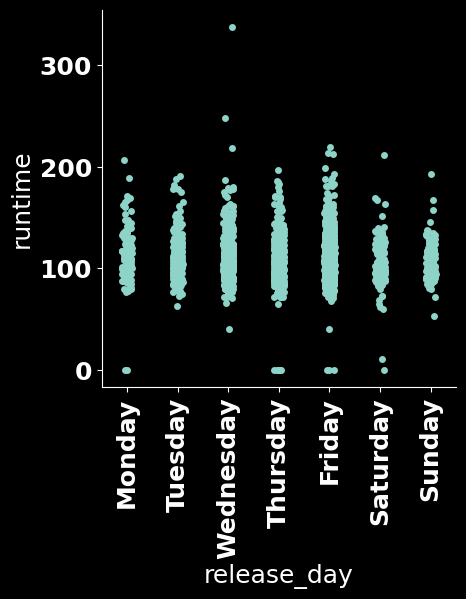

In [133]:
# Plots possible correlation between release day and runtime (no correlation)
sns.catplot(x='release_day',y='runtime',data=train)
plt.gca().set_xticklabels(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],rotation=90)
plt.show()

C:\Users\adamc\AppData\Local\Temp\ipykernel_8720\3323586945.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(month_lst,rotation=90)


<Figure size 1000x1500 with 0 Axes>

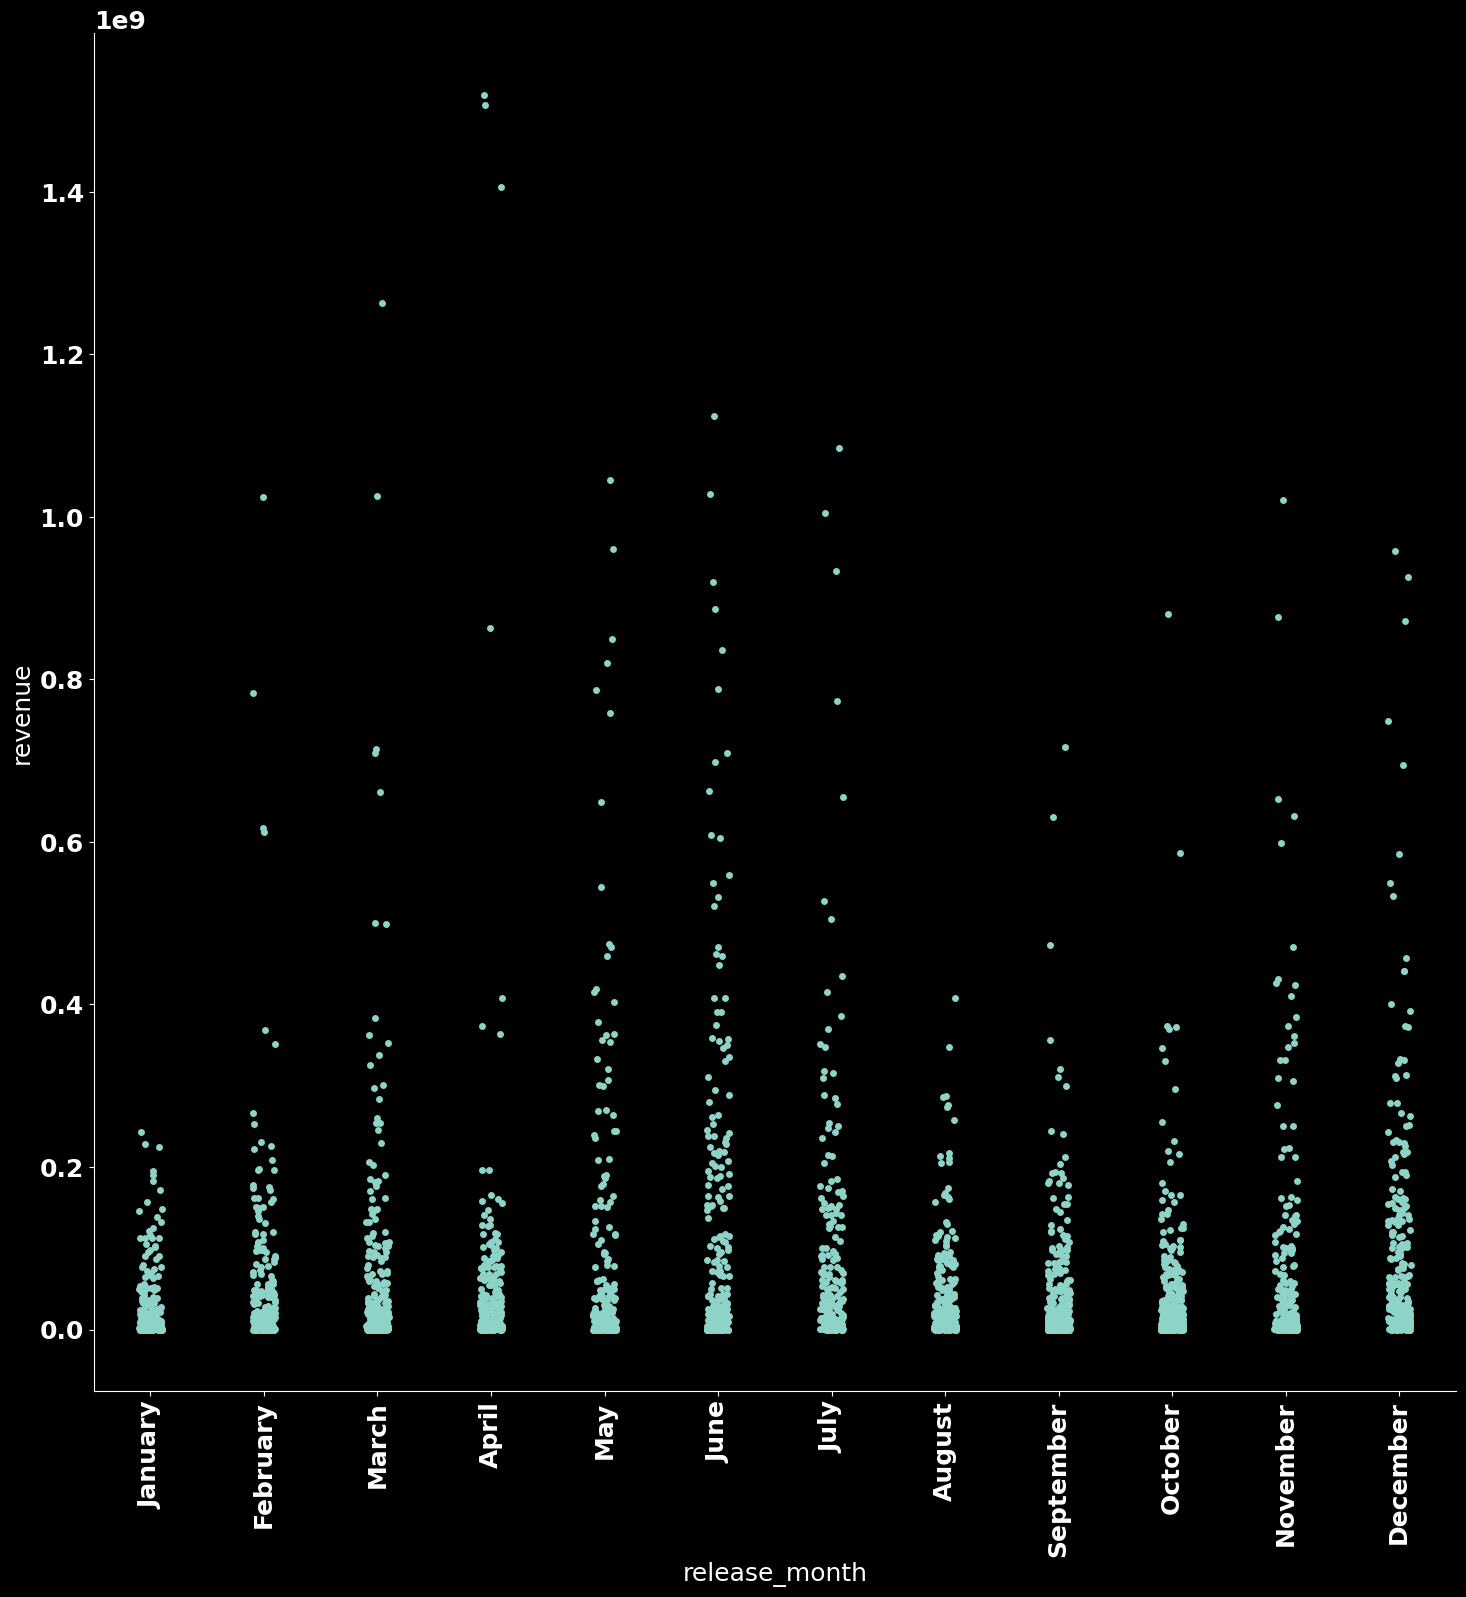

In [132]:
# Plots possible correlation between release month and revenue
plt.figure(figsize=(10,15))
sns.catplot(x='release_month',y='revenue',data=train, height=15, aspect=1)
month_lst = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
              'August', 'September', 'October', 'November', 'December']
plt.gca().set_xticklabels(month_lst,rotation=90)
plt.show()

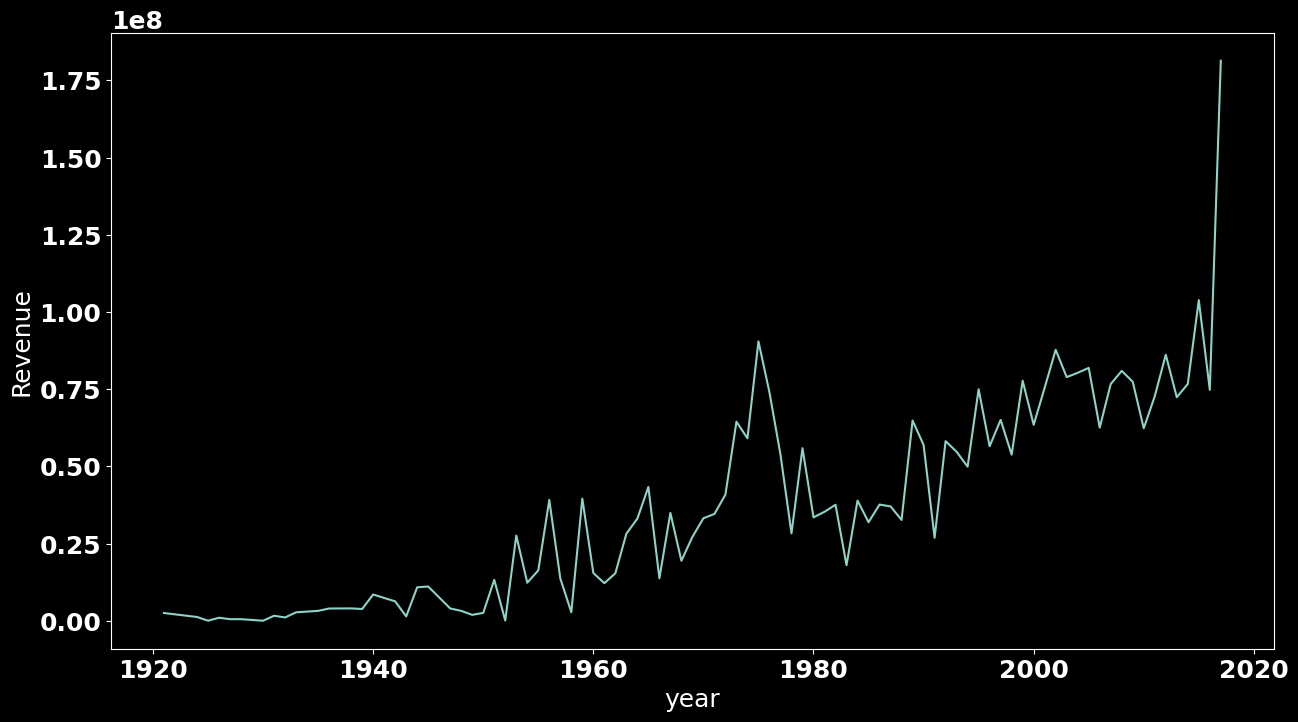

In [86]:
# Shows overall trend of revenue for each year in dataset
plt.figure(figsize=(15,8))
yearly=train.groupby(train['release_year'])['revenue'].agg('mean')
plt.plot(yearly.index,yearly)
plt.xlabel('year')
plt.ylabel("Revenue")
plt.savefig('fig')

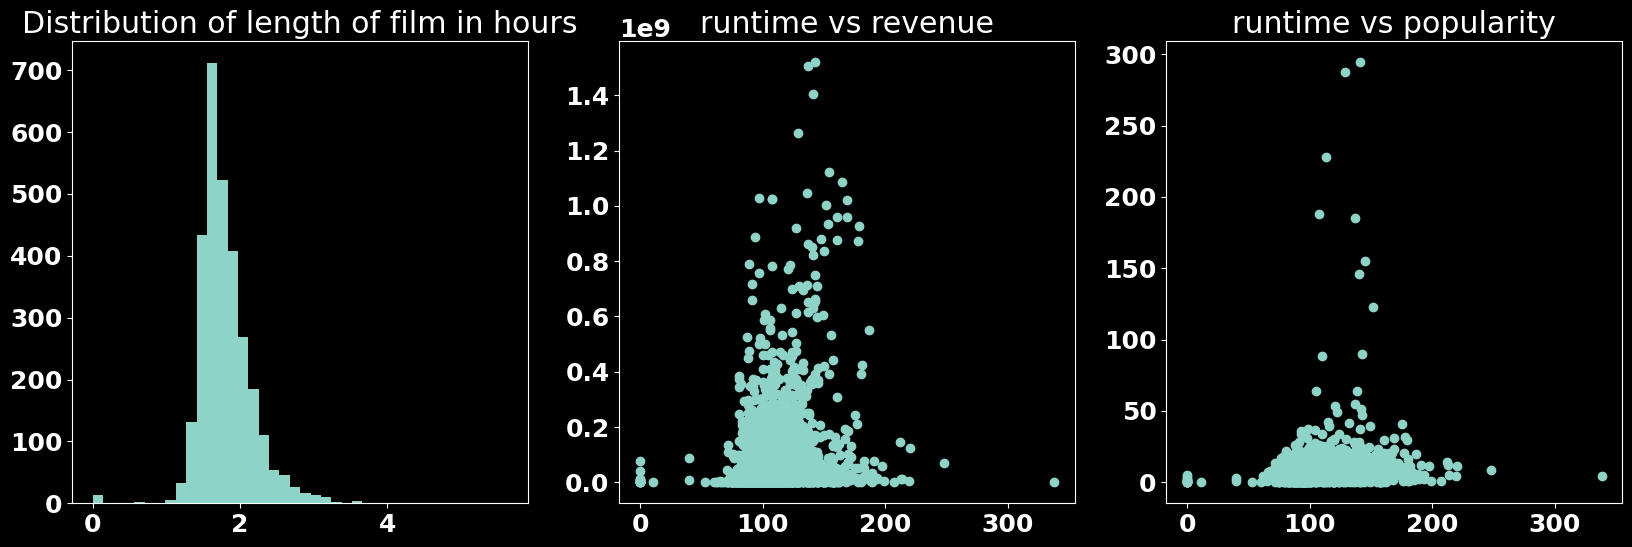

In [135]:
# Shows several other possible correlations
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.hist(train['runtime'].fillna(0) / 60, bins=40);
plt.title('Distribution of length of film in hours');
plt.subplot(1, 3, 2)
plt.scatter(x=train['runtime'].fillna(0), y=train['revenue'])
plt.title('runtime vs revenue');
plt.subplot(1, 3, 3)
plt.scatter(x=train['runtime'].fillna(0), y=train['popularity'])
plt.title('runtime vs popularity');

In [88]:
train['homepage'].value_counts().sort_values(ascending=False)[:5]

http://www.transformersmovie.com/           4
http://www.lordoftherings.net/              2
http://www.thehobbit.com/                   2
http://www.popperspenguins.com/main.html    1
http://www.safethefilm.com/                 1
Name: homepage, dtype: int64

In [89]:
genres=train.loc[train['genres'].str.len()==1][['genres','revenue','budget','popularity','runtime']].reset_index(drop=True)
genres['genres']=genres.genres.apply(lambda x :x[0]['name'])

<AxesSubplot: xlabel='runtime', ylabel='genres'>

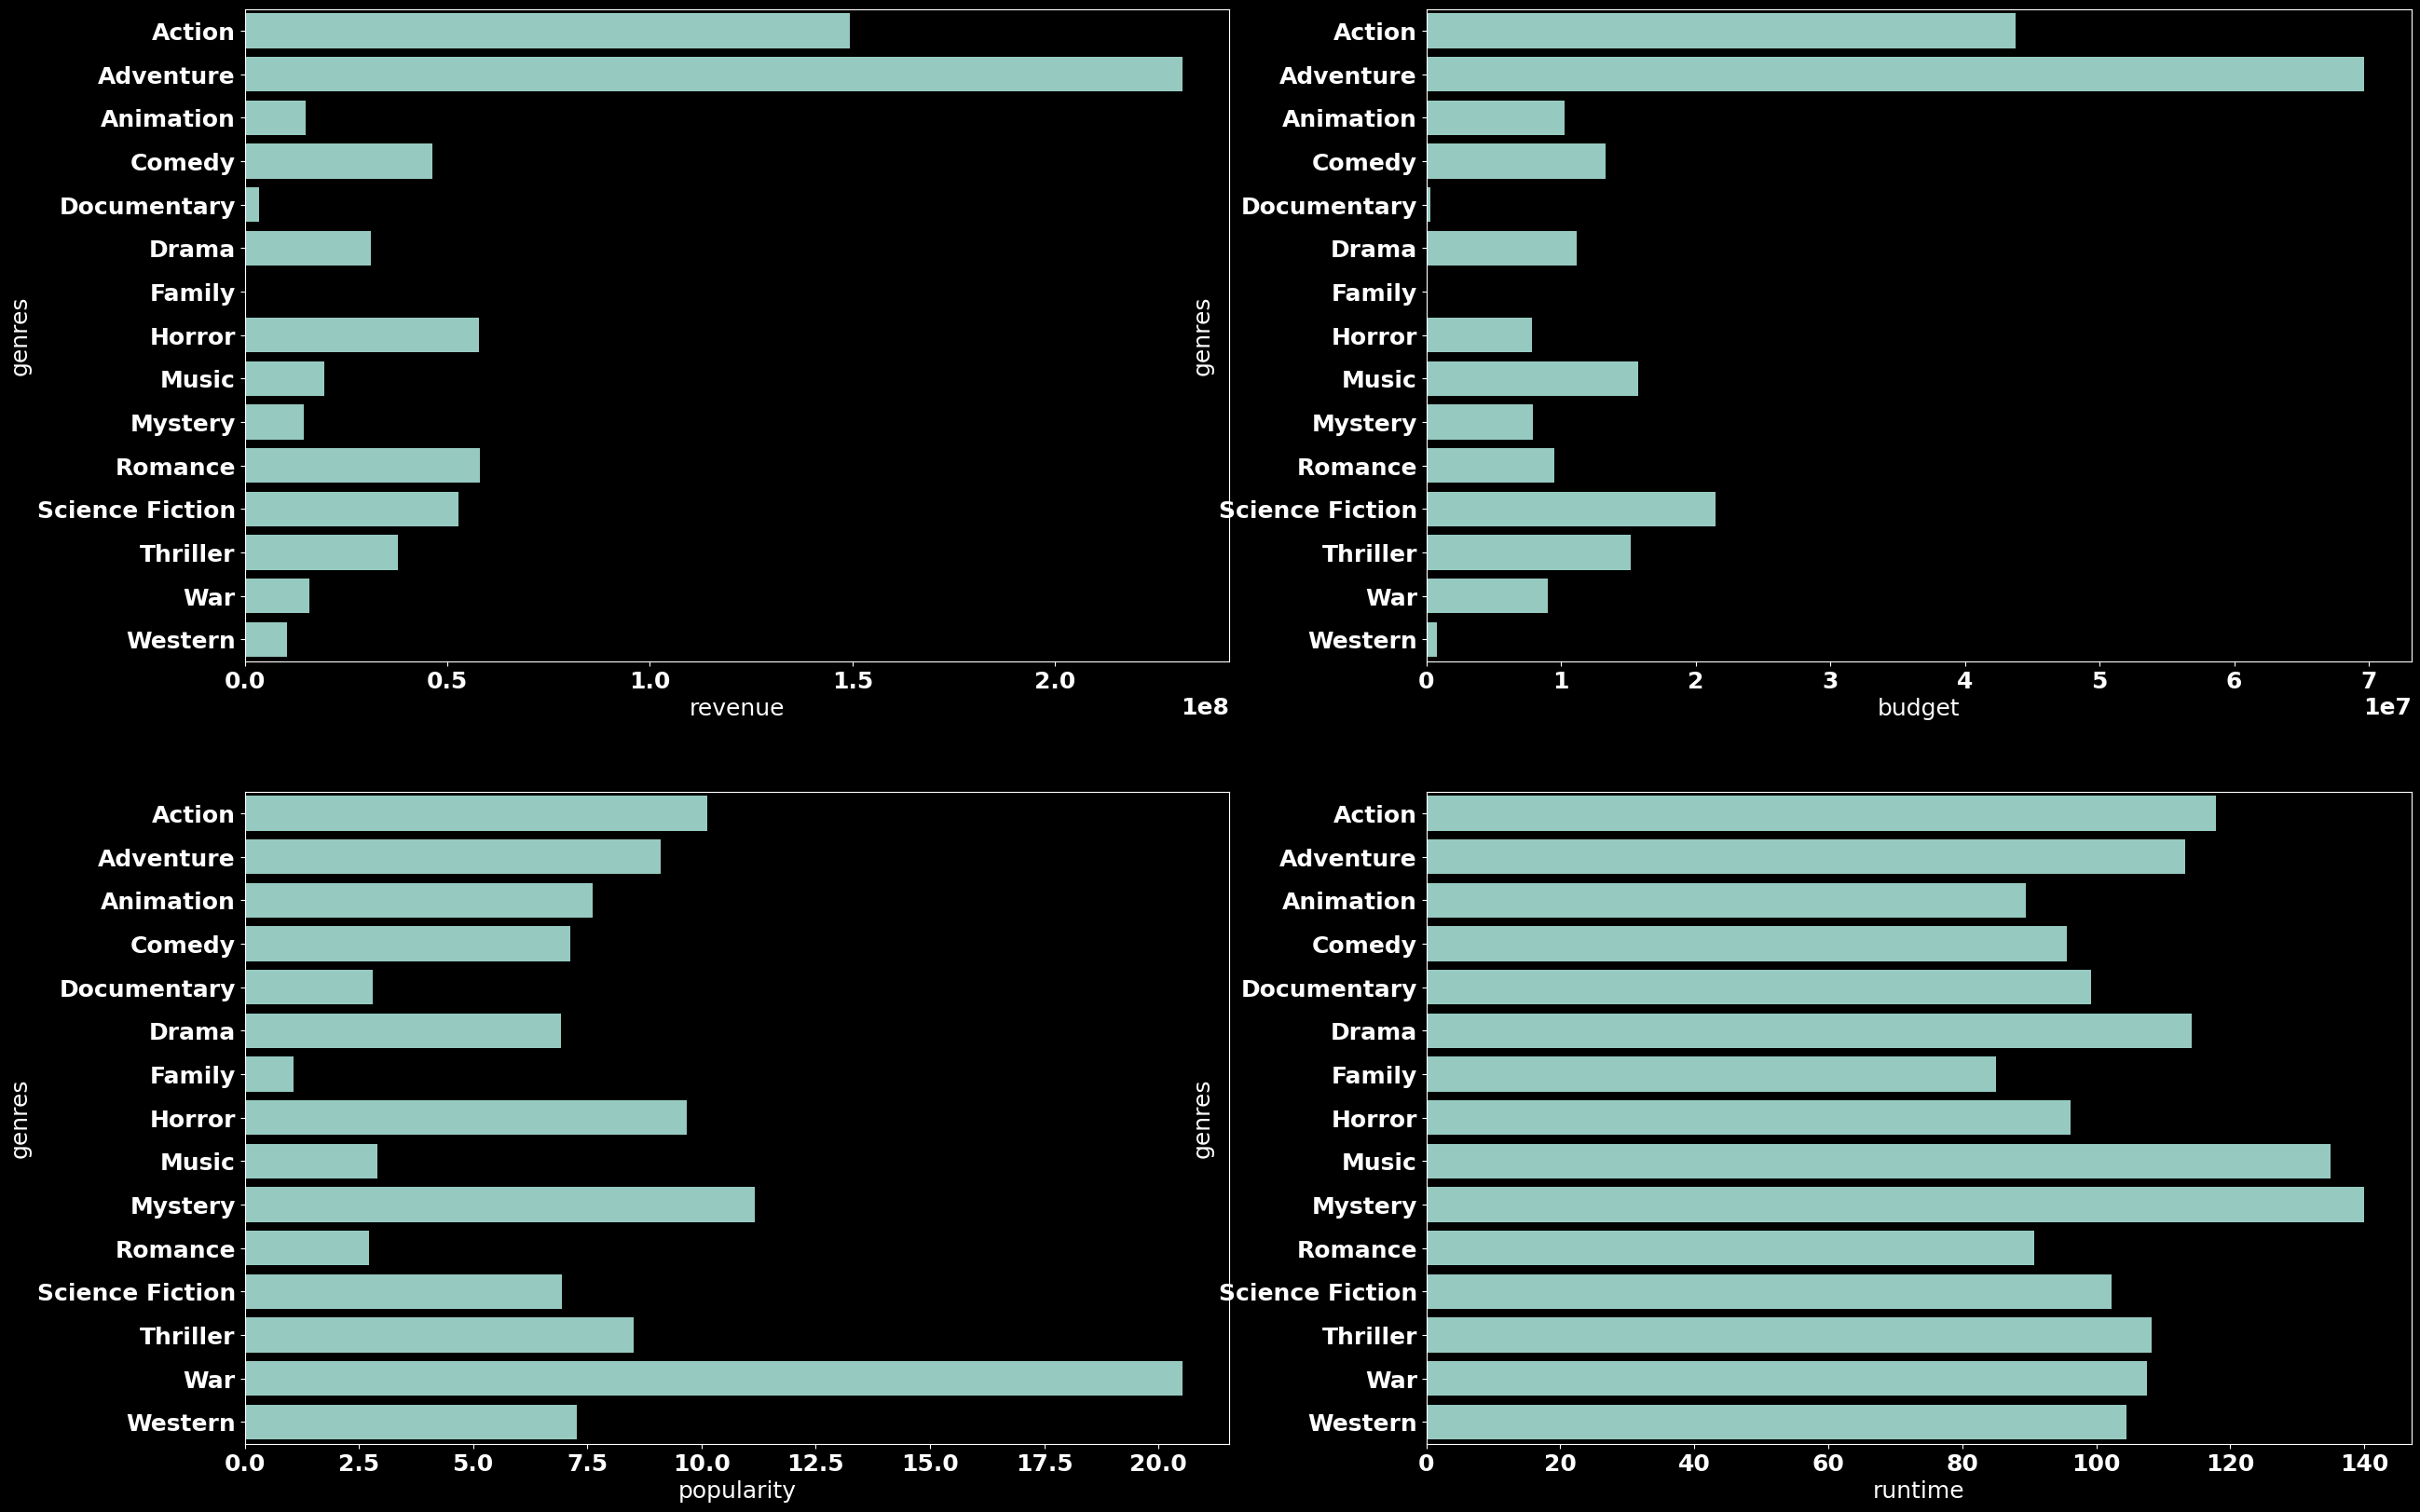

In [90]:
# Plots mean revenue, budget, popularity, and runtime based off each genre
genres=genres.groupby(genres.genres).agg('mean')
plt.figure(figsize=(30,20))
plt.subplot(2,2,1)
sns.barplot(x=genres['revenue'],y=genres.index)

plt.subplot(2,2,2)
sns.barplot(x=genres['budget'],y=genres.index)

plt.subplot(2,2,3)
sns.barplot(x=genres['popularity'],y=genres.index)

plt.subplot(2,2,4)
sns.barplot(x=genres['runtime'],y=genres.index)

In [136]:
# Most common crew members
crew=train['crew'].apply(lambda x:[i['name'] for i in x] if x != {} else [])
Counter([i for j in crew for i in j]).most_common(15)

[('Avy Kaufman', 50),
 ('Robert Rodriguez', 44),
 ('Deborah Aquila', 40),
 ('James Newton Howard', 39),
 ('Mary Vernieu', 38),
 ('Steven Spielberg', 37),
 ('Luc Besson', 37),
 ('Jerry Goldsmith', 37),
 ('Francine Maisler', 35),
 ('Tricia Wood', 35),
 ('James Horner', 33),
 ('Kerry Barden', 32),
 ('Bob Weinstein', 30),
 ('Harvey Weinstein', 30),
 ('Janet Hirshenson', 30)]

In [137]:
# Most common actors
cast=train['cast'].apply(lambda x:[i['name'] for i in x] if x != {} else [])
Counter([i for j in cast for i in j]).most_common(15)

[('Samuel L. Jackson', 30),
 ('Robert De Niro', 30),
 ('Morgan Freeman', 27),
 ('J.K. Simmons', 25),
 ('Bruce Willis', 25),
 ('Liam Neeson', 25),
 ('Susan Sarandon', 25),
 ('Bruce McGill', 24),
 ('John Turturro', 24),
 ('Forest Whitaker', 23),
 ('Willem Dafoe', 23),
 ('Bill Murray', 22),
 ('Owen Wilson', 22),
 ('Nicolas Cage', 22),
 ('Sylvester Stallone', 21)]

In [138]:
def prepare_data(df):
    #Gets additional insights into data by finding ratios
    df['_budget_runtime_ratio'] = (df['budget']/df['runtime']).replace([np.inf,-np.inf,np.nan],0)
    df['_budget_popularity_ratio'] = df['budget']/df['popularity']
    df['_budget_year_ratio'] = df['budget'].fillna(0)/(df['release_year']*df['release_year'])
    df['_releaseYear_popularity_ratio'] = df['release_year']/df['popularity']
    df['_releaseYear_popularity_ratio2'] = df['popularity']/df['release_year']
    df['budget']=np.log1p(df['budget'])
    #fills NA values and encodes data to allow for better learning capabilities
    df['collection_name']=df['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
    df['has_homepage']=0
    df.loc[(pd.isnull(df['homepage'])),'has_homepage']=1

    le=LabelEncoder()
    le.fit(list(df['collection_name'].fillna('')))
    df['collection_name']=le.transform(df['collection_name'].fillna('').astype(str))

    le=LabelEncoder()
    le.fit(list(df['original_language'].fillna('')))
    df['original_language']=le.transform(df['original_language'].fillna('').astype(str))

    df['_num_Keywords'] = df['Keywords'].apply(lambda x: len(x) if x != {} else 0)
    df['_num_cast'] = df['cast'].apply(lambda x: len(x) if x != {} else 0)
    df['isbelongto_coll']=0
    df.loc[pd.isna(df['belongs_to_collection']),'isbelongto_coll']=1

    df['isTaglineNA'] = 0
    df.loc[df['tagline'] == 0 ,"isTaglineNA"] = 1 

    df['isOriginalLanguageEng'] = 0 
    df.loc[ df['original_language'].astype(str) == "en" ,"isOriginalLanguageEng"] = 1

    df['ismovie_released']=1
    df.loc[(df['status']!='Released'),'ismovie_released']=0

    df['no_spoken_languages']=df['spoken_languages'].apply(lambda x: len(x))
    df['original_title_letter_count'] = df['original_title'].str.len() 
    df['original_title_word_count'] = df['original_title'].str.split().str.len() 


    df['title_word_count'] = df['title'].str.split().str.len()
    df['overview_word_count'] = df['overview'].str.split().str.len()
    df['tagline_word_count'] = df['tagline'].str.split().str.len()


    df['collection_id'] = df['belongs_to_collection'].apply(lambda x : np.nan if len(x)==0 else x[0]['id'])
    df['production_countries_count'] = df['production_countries'].apply(lambda x : len(x))
    df['production_companies_count'] = df['production_companies'].apply(lambda x : len(x))
    df['cast_count'] = df['cast'].apply(lambda x : len(x))
    df['crew_count'] = df['crew'].apply(lambda x : len(x))

    df['genders_0_crew'] = df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
    df['genders_1_crew'] = df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
    df['genders_2_crew'] = df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))

    for col in  ['genres', 'production_countries', 'spoken_languages', 'production_companies'] :
        df[col] = df[col].map(lambda x: sorted(list(set([n if n in train_dict[col] else col+'_etc' for n in [d['name'] for d in x]])))).map(lambda x: ','.join(map(str, x)))
        temp = df[col].str.get_dummies(sep=',')
        df = pd.concat([df, temp], axis=1, sort=False)
    df.drop(['genres_etc'], axis = 1, inplace = True)
    cols_to_normalize=['runtime','popularity','budget','_budget_runtime_ratio','_budget_year_ratio','_budget_popularity_ratio','_releaseYear_popularity_ratio',
    '_releaseYear_popularity_ratio2','_num_Keywords','_num_cast','no_spoken_languages','original_title_letter_count','original_title_word_count',
    'title_word_count','overview_word_count','tagline_word_count','production_countries_count','production_companies_count','cast_count','crew_count',
    'genders_0_crew','genders_1_crew','genders_2_crew']
    for col in cols_to_normalize:
        print(col)
        x_array=[]
        x_array=np.array(df[col].fillna(0))
        X_norm=normalize([x_array])[0] #normalize data
        df[col]=X_norm

    df = df.drop(['belongs_to_collection','genres','homepage','imdb_id','overview','id'
    ,'poster_path','production_companies','production_countries','release_date','spoken_languages'
    ,'status','title','Keywords','cast','crew','original_language','original_title','tagline', 'collection_id'],axis=1)

    df.fillna(value=0.0, inplace = True) 

    return df


In [139]:
# creates a dictionary that represents the counts of unique names in specific columns of a DataFrame,
def get_json(df):
    global dict_columns
    result=dict()
    for col in dict_columns:
        d=dict()
        rows=df[col].values
        for row in rows:
            if row is None: continue
            for i in row:
                if i['name'] not in d:
                    d[i['name']]=0
                else:
                    d[i['name']]+=1
            result[col]=d
    return result
    
    

    
train_dict=get_json(train)
test_dict=get_json(test)

In [140]:
#this code is aiming to ensure that the unique names in the specified columns have a minimum count of 10 and are not empty. 
#It removes names that don't meet these criteria
for col in dict_columns :
    
    remove = []
    train_id = set(list(train_dict[col].keys()))
    test_id = set(list(test_dict[col].keys()))   
    
    remove += list(train_id - test_id) + list(test_id - train_id)
    for i in train_id.union(test_id) - set(remove) :
        if train_dict[col][i] < 10 or i == '' :
            remove += [i]
    for i in remove :
        if i in train_dict[col] :
            del train_dict[col][i]
        if i in test_dict[col] :
            del test_dict[col][i]

In [96]:
#Prepares the data using the function defiined above
test['revenue']=np.nan
all_data=prepare_data((pd.concat([train,test]))).reset_index(drop=True)
train=all_data.loc[:train.shape[0]-1,:]
test=all_data.loc[train.shape[0]:,:]

print(train.shape)

runtime
popularity
budget
_budget_runtime_ratio
_budget_year_ratio
_budget_popularity_ratio
_releaseYear_popularity_ratio
_releaseYear_popularity_ratio2
_num_Keywords
_num_cast
no_spoken_languages
original_title_letter_count
original_title_word_count
title_word_count
overview_word_count
tagline_word_count
production_countries_count
production_companies_count
cast_count
crew_count
genders_0_crew
genders_1_crew
genders_2_crew
(3000, 173)


In [97]:
train.drop('revenue',axis=1,inplace=True)
all_data.head()

C:\Users\adamc\AppData\Local\Temp\ipykernel_8720\3860044422.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop('revenue',axis=1,inplace=True)


,budget,popularity,runtime,revenue,log_revenue,log_budget,release_day,release_month,release_year,_budget_runtime_ratio,...,Twentieth Century Fox Film Corporation,UK Film Council,United Artists,Universal Pictures,Village Roadshow Pictures,Walt Disney Pictures,Warner Bros.,Wild Bunch,Working Title Films,production_companies_etc
0,0.013684,0.005148,0.009848,12314651.0,16.326300,16.454568,4,2,2015,0.004637,...,0,0,1,0,0,0,0,0,0,0
1,0.014557,0.006459,0.011966,95149435.0,18.370959,17.504390,4,8,2004,0.010905,...,0,0,0,0,0,1,0,0,0,0
2,0.012482,0.050345,0.011119,13092000.0,16.387512,15.009433,4,10,2014,0.000968,...,0,0,0,0,0,0,0,0,0,1
3,0.011641,0.002486,0.012919,16000000.0,16.588099,13.997833,4,3,2012,0.000303,...,0,0,0,0,0,0,0,0,0,0
4,0.000000,0.000899,0.012495,3923970.0,15.182615,0.000000,3,2,2009,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [98]:
y=train['log_revenue']
X=train.drop(['log_revenue'],axis=1)
     
#Sets training and test split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1)
kfold=KFold(n_splits=3,random_state=42,shuffle=True)
     

print(X.columns)
print(y)

Index(['budget', 'popularity', 'runtime', 'log_budget', 'release_day',
       'release_month', 'release_year', '_budget_runtime_ratio',
       '_budget_popularity_ratio', '_budget_year_ratio',
       ...
       'Twentieth Century Fox Film Corporation', 'UK Film Council',
       'United Artists', 'Universal Pictures', 'Village Roadshow Pictures',
       'Walt Disney Pictures', 'Warner Bros.', 'Wild Bunch',
       'Working Title Films', 'production_companies_etc'],
      dtype='object', length=171)
0       16.326300
1       18.370959
2       16.387512
3       16.588099
4       15.182615
          ...    
2995    14.283442
2996    12.103990
2997    18.309266
2998    18.962792
2999    18.223292
Name: log_revenue, Length: 3000, dtype: float64


In [99]:
#Defines performance metrics
def show_metrics(y_test, y_pred):
    print("Mean Squared Log Error = " + str(metrics.mean_squared_log_error(y_test, y_pred)))
    print("Root Mean Squared Log Error = " + str(np.sqrt(metrics.mean_squared_log_error(y_test, y_pred))))
    print("Mean Squared Error = " + str(metrics.mean_squared_error(y_test, y_pred)))
    print("Root Mean Squared Error = " + str(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))
    print("R^2 = " + str(metrics.r2_score(y_test, y_pred)))

In [100]:
#LGBM Regression
def msle(y_true, y_pred):
    return 'MSLE', np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2))), False

params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}

model_lgb = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)

model_lgb.fit(X_train, y_train)



prediction_lgb_test=model_lgb.predict(X_test)

show_metrics(y_test, prediction_lgb_test)

Mean Squared Log Error = 0.05298694567950233
Root Mean Squared Log Error = 0.23018893474600888
Mean Squared Error = 5.697639837330641
Root Mean Squared Error = 2.38697294440692
R^2 = 0.4747092660702321


In [103]:
#creates simple RBF with no parameter tuning
rf_base = RandomForestRegressor(random_state=42)
rf_base.fit(X_train, y_train)
y_rf_base_pred = rf_base.predict(X_test)
print("Base Random Forest Regressor:\n")
show_metrics(y_test, y_rf_base_pred)

#defines set of parameters
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

#checks for best parameters and fits model to those parameters
print("\nTuned Random Forest Regressor:\n")
rf = RandomForestRegressor(**random_grid)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 75, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

Base Random Forest Regressor:

Mean Squared Log Error = 0.05380581841362352
Root Mean Squared Log Error = 0.2319608122369456
Mean Squared Error = 5.430987659996475
Root Mean Squared Error = 2.3304479526469746
R^2 = 0.4992931151612371

Tuned Random Forest Regressor:

Fitting 3 folds for each of 75 candidates, totalling 225 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestRegressor(bootstrap=[True, False],
                                                   max_depth=[10, 20, 30, 40,
                                                              50, 60, 70, 80,
                                                              90, 100, 110,
                                                              None],
                                                   max_features=['auto',
                                                                 'sqrt'],
                                                   min_samples_leaf=[1, 2, 4],
                                                   min_samples_split=[2, 5, 10],
                                                   n_estimators=[200, 400, 600,
                                                                 800, 1000,
                                                                 1200, 1400,
                                                                 1600, 1800,
                                                                 2000]),
                   n_iter=75, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [104]:
#reruns RBF algorithm with best parameters
y_rf_pred = rf_random.predict(X_test)
show_metrics(y_test, y_rf_pred)
print("\nWith the following parameters:")
print(rf_random.best_params_)

Mean Squared Log Error = 0.054407985503646554
Root Mean Squared Log Error = 0.2332551939478445
Mean Squared Error = 5.455821071520932
Root Mean Squared Error = 2.3357699097986795
R^2 = 0.4970036126061276

With the following parameters:
{'n_estimators': 1400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 80, 'bootstrap': False}


In [ ]:
#XG boost model
def xgb_model(X_train, y_train, X_test, y_test) :  
  params = {'objective': 'reg:linear', 
    'eta': 0.01, 
    'max_depth': 6, 
    'subsample': 0.6, 
    'colsample_bytree': 0.7,  
    'eval_metric': 'rmse', 
    'seed': 2020, 
    'silent': True,
  }
  
  record = dict()

  train_data = xgb.DMatrix(data=X_train, label=y_train)

  model = xgb.train(dtrain=train_data, num_boost_round=20000, params=params)

  test_pred = model.predict(xgb.DMatrix(X_test))

  show_metrics(y_test, test_pred)

xgb_model(X_train, y_train, X_test, y_test)

c:\Users\adamc\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [04:19:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
c:\Users\adamc\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [04:19:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


Mean Squared Log Error = 0.05624516335952999
Root Mean Squared Log Error = 0.2371606277600268
Mean Squared Error = 5.401335055052137
Root Mean Squared Error = 2.324077248081943
R^2 = 0.43684369212983876


In [ ]:
# Cat boost model
from catboost import CatBoostRegressor

def cat_model(X_train, y_train, X_test, y_test) :    
  model = CatBoostRegressor(iterations=10000,
  learning_rate=0.004,
  depth=5,
  colsample_bylevel=0.8,
  random_seed = 2020,
  bagging_temperature = 0.2,
  metric_period = None,
  )

  model.fit(X_train, y_train,
    verbose=False)
  
  test_pred = model.predict(X_test)

  show_metrics(y_test, test_pred)

cat_model(X_train, y_train, X_test, y_test)

Mean Squared Log Error = 0.045915613586588
Root Mean Squared Log Error = 0.21427928874855826
Mean Squared Error = 4.34689408228257
Root Mean Squared Error = 2.0849206417229817
R^2 = 0.5467822682484422


In [106]:
# Elastic net and Elastic net with builtin grid search CV
elastic_net_model = ElasticNet(random_state=42)
elastic_net_model.fit(X_train, y_train)
y_elastic_pred = elastic_net_model.predict(X_test)
show_metrics(y_test, y_elastic_pred)
     

print(elastic_net_model.get_params())
     

elastic_netCV_model = ElasticNetCV(cv=5, random_state=42)
elastic_netCV_model.fit(X_train, y_train)
y_elastic_CV_pred = elastic_netCV_model.predict(X_test)
show_metrics(y_test, y_elastic_CV_pred)

Mean Squared Log Error = 0.0698645448376066
Root Mean Squared Log Error = 0.26431902095310245
Mean Squared Error = 8.418082861638194
Root Mean Squared Error = 2.9013932621480656
R^2 = 0.2238995354358484
{'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.5, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': 42, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
Mean Squared Log Error = 0.06936885567684926
Root Mean Squared Log Error = 0.2633796796961551
Mean Squared Error = 8.290179598629962
Root Mean Squared Error = 2.8792671981999103
R^2 = 0.23569150558766538


In [ ]:
#Ridged Regression
ridged_model = Ridge(random_state=42)
ridged_model.fit(X_train, y_train)
y_ridge_pred = ridged_model.predict(X_test)
show_metrics(y_test, y_ridge_pred)
     
#Ridged Regression with grid search CV builtin
ridgeCV_model = RidgeCV(alphas=[0.0005, 0.001, 0.00125, 0.0015, 0.00175, 0.002])
ridgeCV_model.fit(X_train, y_train)
y_ridgeCV_pred = ridgeCV_model.predict(X_test)
show_metrics(y_test, y_ridgeCV_pred)
print("Optimal alpha: " + str(ridgeCV_model.alpha_))
     

#linear kernel
kernel_ridge_model = KernelRidge(alpha=ridgeCV_model.alpha_)
kernel_ridge_model.fit(X_train, y_train)
y_kernel_ridge_pred = kernel_ridge_model.predict(X_test)
show_metrics(y_test, y_kernel_ridge_pred)

Mean Squared Log Error = 0.05399952147176227
Root Mean Squared Log Error = 0.23237797114133316
Mean Squared Error = 5.3982503028464865
Root Mean Squared Error = 2.3234135023379903
R^2 = 0.4371653158849146
Mean Squared Log Error = 0.05470455948166388
Root Mean Squared Log Error = 0.2338900585353381
Mean Squared Error = 5.575023363121569
Root Mean Squared Error = 2.3611487380344274
R^2 = 0.4187345273963704
Optimal alpha: 0.0015
Mean Squared Log Error = 0.054703691933698055
Root Mean Squared Log Error = 0.23388820392165582
Mean Squared Error = 5.575560067019785
Root Mean Squared Error = 2.3612623884311934
R^2 = 0.4186785693447669


In [ ]:
# Linear Regression
lm = LinearRegression()
lm.fit(X_train, y_train)
y_lm_pred = lm.predict(X_test)
show_metrics(y_test, y_lm_pred)

Mean Squared Log Error = 0.05387076282578221
Root Mean Squared Log Error = 0.2321007600715306
Mean Squared Error = 5.461319258232852
Root Mean Squared Error = 2.3369465672609744
R^2 = 0.43058959345803194


In [ ]:
#Support Vector Regression
from sklearn.svm import SVR

Cval = 100
eps= 1

SVRreg = SVR(C=Cval, epsilon=eps)
SVRreg.fit(X_train,y_train)
y_pred = SVRreg.predict(X_test)
show_metrics(y_test, y_pred)

Mean Squared Log Error = 0.0662506775812679
Root Mean Squared Log Error = 0.25739206977152174
Mean Squared Error = 7.426512952420644
Root Mean Squared Error = 2.7251629221792677
R^2 = 0.22569372719745662


In [ ]:
# Optimization of hyperparameters for SVR
from sklearn.model_selection import GridSearchCV
params_selection = {
    "C": np.linspace(10, 200, 10),
    "epsilon": np.linspace(.02, 6, 10),
}

clf = GridSearchCV(SVR(), params_selection, verbose=5)
res = clf.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END ..............C=10.0, epsilon=0.02;, score=0.090 total time=   0.4s
[CV 2/5] END ..............C=10.0, epsilon=0.02;, score=0.087 total time=   0.6s
[CV 3/5] END ..............C=10.0, epsilon=0.02;, score=0.097 total time=   0.6s
[CV 4/5] END ..............C=10.0, epsilon=0.02;, score=0.041 total time=   0.4s
[CV 5/5] END ..............C=10.0, epsilon=0.02;, score=0.035 total time=   0.4s
[CV 1/5] END C=10.0, epsilon=0.6844444444444445;, score=0.097 total time=   0.3s
[CV 2/5] END C=10.0, epsilon=0.6844444444444445;, score=0.094 total time=   0.4s
[CV 3/5] END C=10.0, epsilon=0.6844444444444445;, score=0.101 total time=   0.3s
[CV 4/5] END C=10.0, epsilon=0.6844444444444445;, score=0.049 total time=   0.2s
[CV 5/5] END C=10.0, epsilon=0.6844444444444445;, score=0.040 total time=   0.4s
[CV 1/5] END .C=10.0, epsilon=1.348888888888889;, score=0.112 total time=   0.2s
[CV 2/5] END .C=10.0, epsilon=1.34888888888888

In [ ]:
res.cv_results_

{'mean_fit_time': array([0.36547427, 0.26080923, 0.20118256, 0.11787024, 0.09054461,
        0.06322727, 0.04504943, 0.03224392, 0.02101126, 0.02496271,
        0.31467528, 0.24911199, 0.19188337, 0.13048754, 0.09614968,
        0.07345662, 0.04307737, 0.03391061, 0.03277397, 0.02756615,
        0.34880681, 0.24870801, 0.170541  , 0.12267885, 0.08686085,
        0.0630991 , 0.04737496, 0.03481865, 0.02415423, 0.0199451 ,
        0.32218289, 0.38387704, 0.16491799, 0.11638484, 0.08542805,
        0.06883941, 0.05589633, 0.05442171, 0.02790861, 0.02396097,
        0.31030421, 0.24083986, 0.18769813, 0.15407076, 0.13360848,
        0.08251634, 0.05870094, 0.052353  , 0.03173065, 0.02091355,
        0.3330853 , 0.21844692, 0.15722799, 0.12181182, 0.08447118,
        0.05427151, 0.0430934 , 0.03109884, 0.02647939, 0.02294202,
        0.32429695, 0.22423544, 0.16114812, 0.10917702, 0.08016114,
        0.06094041, 0.04533234, 0.0326612 , 0.02710309, 0.02356839,
        0.30790157, 0.22799711,

In [ ]:
 #Best Model Test Results
print("Best Selected Model with params {}".format(res.best_params_))
best_model = res.best_estimator_
y_pred = best_model.predict(X_test)
show_metrics(y_test, y_pred)

Best Selected Model with params {'C': 200.0, 'epsilon': 2.0133333333333336}
Mean Squared Log Error = 0.06426479176374789
Root Mean Squared Log Error = 0.25350501329115344
Mean Squared Error = 7.202919197453662
Root Mean Squared Error = 2.6838254782033912
R^2 = 0.24900615500032985


In [ ]:
# Finds 20 most correlated features using pearson coefficient
cor = train.corr(method ='pearson')
cor_target = abs(cor["log_revenue"])
relevant_features = cor_target[cor_target>0.19]
features_names = [f for f in relevant_features.index.values if f != 'log_revenue']
print(features_names)
print(len(features_names))

minimized_X_train = X_train[features_names]
minimized_X_test = X_test[features_names]

['budget', 'popularity', 'runtime', 'log_budget', '_budget_runtime_ratio', '_budget_year_ratio', '_releaseYear_popularity_ratio2', 'collection_name', '_num_Keywords', '_num_cast', 'production_companies_count', 'cast_count', 'crew_count', 'genders_0_crew', 'genders_1_crew', 'genders_2_crew', 'Adventure', 'Documentary', 'United States of America', 'English']
20


In [ ]:
# Testing with features above using SVR
print("Training with Top 20 Correlated Features using RBF Kernel")
SVRreg = SVR(C=200, epsilon=1.67)
SVRreg.fit(minimized_X_train,y_train)
y_pred = SVRreg.predict(minimized_X_test)
show_metrics(y_test, y_pred)

Training with Top 20 Correlated Features using RBF Kernel
Mean Squared Log Error = 0.06155628873998215
Root Mean Squared Log Error = 0.248105398449897
Mean Squared Error = 6.64288058670705
Root Mean Squared Error = 2.577378626959386
R^2 = 0.30739714039157995


In [ ]:
# Using PCA to find 20 components
from sklearn.decomposition import PCA

pca = PCA(n_components=20)
pca_X_train = pca.fit_transform(X_train)
pca_X_test = pca.transform(X_test)
pca.explained_variance_ratio_

array([9.90732682e-01, 7.12813662e-03, 1.61610080e-03, 3.46293564e-04,
       5.07030049e-05, 1.06047528e-05, 9.02797636e-06, 7.28292119e-06,
       6.28507853e-06, 5.13519319e-06, 4.87678103e-06, 4.50097715e-06,
       4.01916382e-06, 3.67036320e-06, 3.24301546e-06, 2.96606620e-06,
       2.90794904e-06, 2.37310907e-06, 2.18003146e-06, 2.06484889e-06])

In [ ]:
# Testing with SVR and PCA applied
print("Training with 20-component PCA Features using RBF Kernel")
SVRreg = SVR(C=Cval, epsilon=eps)
SVRreg.fit(pca_X_train,y_train)
y_pred = SVRreg.predict(pca_X_test)
show_metrics(y_test, y_pred)

Training with 20-component PCA Features using RBF Kernel
Mean Squared Log Error = 0.06244537740047259
Root Mean Squared Log Error = 0.24989073092148215
Mean Squared Error = 6.658111094601848
Root Mean Squared Error = 2.580331586172957
R^2 = 0.30580917065713453
